This is a testing notebook for processing IRE1 cluster data based on an HDF5 output file from Cell Profiler.

In [1]:
# load modules

# uncomment for debugging
%load_ext autoreload
%autoreload 2
%matplotlib

import os, sys, inspect
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import h5py
import re
from pprint import pprint
import time
import seaborn as sns
import warnings


# Disable future warnings for seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)


# Add source code directory (src) to path to enable module import
curr_frame = inspect.getfile(inspect.currentframe())
curr_dir = os.path.dirname(os.path.abspath(curr_frame))
parent_dir = os.path.dirname(curr_dir)
module_dir = os.path.join(parent_dir, 'src')
os.sys.path.insert(0, module_dir)

import cellprofiler_tools as cpt


Using matplotlib backend: Qt5Agg


In [2]:
# Load any required data from HDF5 file
# Path to raw HDF5 file
data_dir = '../data/processed/CellProfiler_IRE1clusters_test'
file_name = 'ClusterQuant__1.h5'
full_file = os.path.join(data_dir, file_name)


images = cpt.get_data_cp_hdf5(full_file, obj='Image',data_fields=['ImageNumber','FileName_DNA_DAPI'])
#er_filt = cpt.get_data_cp_hdf5(full_file, obj='ER_masks_filtered',data_fields=[])
er_masks = cpt.get_data_cp_hdf5(full_file, obj='ER_masks',data_fields=[])
ire1_clust = cpt.get_data_cp_hdf5(full_file, obj='IRE1_clusters',data_fields=[])

rel_masksfilt_clust = cpt.get_relationship_cp_hdf5(full_file, "ER_masks_filtered", "IRE1_clusters")
rel_masksfilt_nuclei = cpt.get_relationship_cp_hdf5(full_file, "ER_masks_filtered", "Nuclei")
rel_nuclei_masks = cpt.get_relationship_cp_hdf5(full_file, "Nuclei", "ER_masks")

print("loaded")


loaded


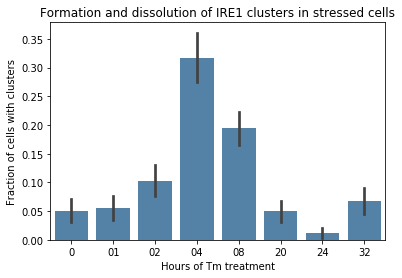

In [4]:
# Plot fraction of cells with clusters per condition

# Create a dataframe for all cells that are included in the analysis
m_n_sorted = rel_masksfilt_nuclei.sort_values(by=['ImageNumber_First', 'ObjectNumber_Second'])
cells = m_n_sorted.loc[:,('ImageNumber_Second', 'ObjectNumber_Second')]
cells.reset_index(drop=True, inplace=True)
cells.index.name = 'Cell_ID'

cells.rename(columns={'ImageNumber_Second':'ImgNum',
                     'ObjectNumber_Second':"NucleusNum"}, inplace=True)


# Establish relationships between cell nuclei, ER masks objects, and IRE1 clusters
mask_ids = []
clust_ids = []
hours_tm = [] # hours of tunicamycin treatment
positions = []
img_names = []
for index, cell in cells.iterrows():
    
    # Get ID of ER mask associated with each cell
    er_mask_id = rel_nuclei_masks.loc[((rel_nuclei_masks['ImageNumber_First'] == cell['ImgNum']) 
                & (rel_nuclei_masks['ObjectNumber_First'] == cell['NucleusNum'])),'ObjectNumber_Second']
    er_mask = er_mask_id.iat[0]
    
    # Get ID of IRE1 clusters associated with each cell
    ire_clust_id = rel_masksfilt_clust.loc[((rel_masksfilt_clust['ImageNumber_First'] == cell['ImgNum']) 
                & (rel_masksfilt_clust['ObjectNumber_First'] == er_mask)),'ObjectNumber_Second']
    
    # Parse the tunicamycin treatment duration from file name
    img_name = images.loc[images['ImageNumber'] == cell['ImgNum'], 'FileName_DNA_DAPI']
    img_name = img_name.iat[0].decode("utf-8")
    hrs_tm_match = re.match(r".*_(\d+)hTm_.*", img_name)
    pos_match = re.match(r".*_Pos(\d+).*", img_name)
    pos = pos_match.group(1)
    hrs_tm = hrs_tm_match.group(1)
    
    mask_ids.append(er_mask)
    clust_ids.append(list(ire_clust_id))
    hours_tm.append(hrs_tm)
    positions.append(pos)
    img_names.append(img_name)
    
cells['ER_MaskNum'] = mask_ids
cells['IRE1_clust_IDs'] = clust_ids
cells['Hrs_Tm'] = hours_tm
cells['ImgName'] = img_names
cells['Position'] = positions
cells['NumClusters'] = [len(row.IRE1_clust_IDs) for row in cells.itertuples()]


fraction_clust = {}
bootstrap_nreps = 1000
conditions_unique = cells['Hrs_Tm'].unique()

for condition in conditions_unique:
    cells_in_cond = cells.loc[cells['Hrs_Tm'] == condition]
    total_cells = len(cells_in_cond)
    
    # Bootstrap the samples to estimate uncertainties
    metric = []
    for i in range(bootstrap_nreps):
        subsamp_cells = np.random.choice(list(cells_in_cond['NumClusters']), total_cells)
        num_cells_with_clust = np.count_nonzero(subsamp_cells)
        fraction_with_clust = num_cells_with_clust / total_cells
        metric.append(fraction_with_clust)
    
    fraction_clust.update({condition : metric})

frac_clust = pd.DataFrame(data=fraction_clust)

ax = sns.barplot(data=frac_clust, color='steelblue', ci="sd")
ax.set_title('Formation and dissolution of IRE1 clusters in stressed cells')
ax.set_xlabel('Hours of Tm treatment')
ax.set_ylabel('Fraction of cells with clusters')
ax.set_ylim(bottom=0)
plt.show()

In [ ]:
# Load test data
# Path to raw HDF5 file
data_dir = '../data/processed/CellProfiler_IRE1clusters_test'
file_name = 'ClusterQuant__1.h5'
full_file = os.path.join(data_dir, file_name)


#df = cpt.get_data_cp_hdf5(full_file, obj='Image',data_fields=[])

df_rel = cpt.get_relationship_cp_hdf5(full_file, "ER_masks_filtered", "IRE1_clusters")


#print(df[['ImageNumber','ObjectNumber', 'AreaShape_Area']])
#print(df)
print(df_rel)


In [ ]:
"""
# Uncomment for a quick timer
start = time.time()
print("Start timer")

end = time.time()
print(end - start)
"""

In [ ]:
string = 'C1-AVG_vVB_190416_03_Well03_02hTm_1_MMStack_Pos0.ome.tif'


z = re.match(r".*_(\d+)hTm_.*", string)

print(z.group(1))

